In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import pour prétraitement du texte
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#Import pour créer le réseau de neurone
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

##### Préparation des données
J'ai pré enregistrer un csv avec les commentaire nettoyés (sans chiffres, ponctuations et stopwords) pour pas avoir a refaire le traitement à chaque fois et gagner du temps.

In [2]:
data = pd.read_csv('./data/clean_data_imdb.csv')
data = data.replace({1.0:'positive',0.0:'negative'})
data.head()

,text,label
0,Bromwell High cartoon comedy run time program ...,positive
1,Homelessness Houselessness George Carlin state...,positive
2,brilliant act Lesley Ann Warren well dramatic ...,positive
3,easily underrated film inn Brooks cannon sure ...,positive
4,typical Mel Brooks film slapstick movie actual...,positive


##### Vectorisation des commentaires

In [3]:
# j'utilise la classe Tokenizer de keras preprocessing pour vectoriser mes commentaires avec 2000 mots de vocabulaire maximum.
tokenizer = Tokenizer(num_words=2000) # => création du tokenizer
tokenizer.fit_on_texts(data['text'].values) # => calibrage du tokenizer (correspond au .fit avec le tfidf)
X = tokenizer.texts_to_sequences(data['text'].values) # => vectorisation des commentaires (correspond au .transform avec le tfidf)

In [4]:
# dans keras preprocessing, pad_sequences permet de faire en sorte que tout les vecteurs aient la même longueur pour les donner au modèle
X = pad_sequences(X)

##### Preparation des labels
One hot encoding des labels pour le réseau de neurones

In [5]:
Y = pd.get_dummies(data['label']).values

##### Séparation des données d'entraînement et de test

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(37500, 686) (37500, 2)
(12500, 686) (12500, 2)


##### Création du réseau de neurones

In [7]:
model = Sequential()
model.add(Embedding(2000, 64, input_length = X.shape[-1])) # => remplacer 2000 par le nombre de mots de votre vocabulaire
model.add(SpatialDropout1D(0.4))
model.add(LSTM(60, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax')) # => remplacer 2 par le nombre de classe à prédire (garder 2 si vous faite une classification binaire)

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 686, 64)           128000    
                                                                 
 spatial_dropout1d (Spatial  (None, 686, 64)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 60)                30000     
                                                                 
 dense (Dense)               (None, 2)                 122       
                                                                 
Total params: 158122 (617.66 KB)
Trainable params: 158122 (617.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


##### Entraînement du réseau de neurones
Entraînement très long, plus d'une heure en local, mais vous pouvez eventuellement utiliser google colab (entrainement dans le cloud google) pour accélerer les choses.

In [8]:
history = model.fit(X_train, Y_train, epochs = 10, batch_size = 64, validation_data=(X_test,Y_test))

Epoch 1/10
586/586 [==============================] - 531s 896ms/step - loss: 0.3982 - accuracy: 0.8195 - val_loss: 0.3201 - val_accuracy: 0.8650
Epoch 2/10
586/586 [==============================] - 554s 946ms/step - loss: 0.3117 - accuracy: 0.8726 - val_loss: 0.3107 - val_accuracy: 0.8693
Epoch 3/10
586/586 [==============================] - 652s 1s/step - loss: 0.2956 - accuracy: 0.8755 - val_loss: 0.3114 - val_accuracy: 0.8718
Epoch 4/10
586/586 [==============================] - 774s 1s/step - loss: 0.2870 - accuracy: 0.8803 - val_loss: 0.3108 - val_accuracy: 0.8732
Epoch 5/10
586/586 [==============================] - 818s 1s/step - loss: 0.2792 - accuracy: 0.8838 - val_loss: 0.3254 - val_accuracy: 0.8702
Epoch 6/10
586/586 [==============================] - 829s 1s/step - loss: 0.2716 - accuracy: 0.8867 - val_loss: 0.3071 - val_accuracy: 0.8714
Epoch 7/10
586/586 [==============================] - 856s 1s/step - loss: 0.2612 - accuracy: 0.8913 - val_loss: 0.3186 - val_accuracy: 

##### Evaluation du modèle

Courbes d'apprentissage du réseau de neurone

C:\Users\Gharib\AppData\Local\Temp\ipykernel_17792\41887351.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


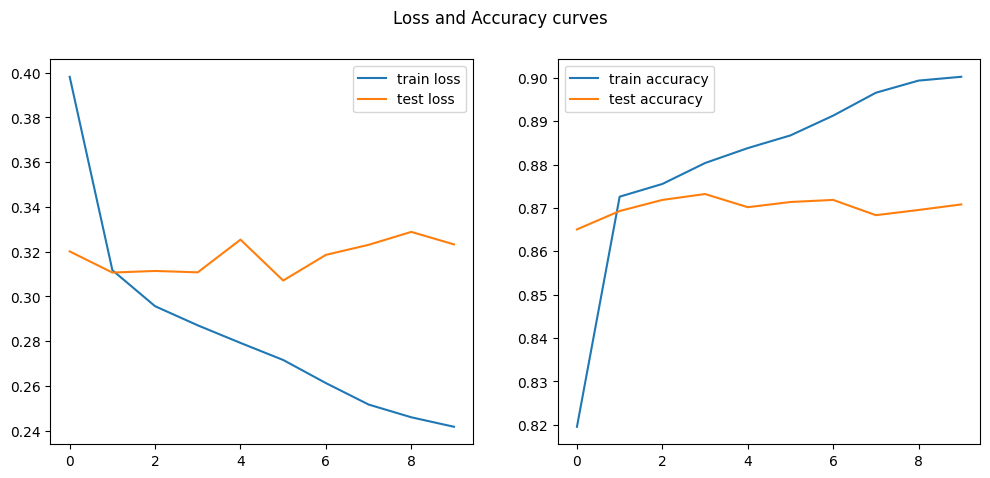

In [9]:
losss = history.history['loss']
accu = history.history['accuracy']
val_loss = history.history['val_loss']
val_accu = history.history['val_accuracy']
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Loss and Accuracy curves')
ax1.plot(losss, label='train loss')
ax1.plot(val_loss, label='test loss')
ax1.legend(loc="upper right")
ax2.plot(accu, label='train accuracy')
ax2.plot(val_accu, label='test accuracy')
ax2.legend()
fig.show()

Prédiction sur l'ensemble de test

In [10]:
predictions = model.predict(X_test)

391/391 [==============================] - 136s 346ms/step


Accuracy Score et Matrice de confusion

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [13]:
print(accuracy_score(Y_test, predictions))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [14]:
cm = confusion_matrix(predictions, Y_test)

f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multilabel-indicator targets